# ΓΙΑΝΝΗΣ ΚΑΡΑΒΕΛΛΑΣ
# 4228

In [8]:
import numpy as np
import cupy as cp
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tqdm import tqdm
import random

Loading the data

In [9]:
cp.random.seed(42)  
np.random.seed(42)
random.seed(42)
# Load the dataset
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()

# Flatten label arrays
y_train_full = y_train_full.flatten()
y_test_full = y_test_full.flatten()


Extracting only 'cat' and 'dog' lables

In [10]:
# Define the classes
class_map = {5: 'dog', 3: 'cat'}

# Filter training data
train_filter = np.isin(y_train_full, list(class_map.keys()))
x_train = x_train_full[train_filter]
y_train = y_train_full[train_filter]

# Filter test data
test_filter = np.isin(y_test_full, list(class_map.keys()))
x_test = x_test_full[test_filter]
y_test = y_test_full[test_filter]

# Map labels to +1 and -1
label_map = {5: 1, 3: -1}
y_train = np.vectorize(label_map.get)(y_train)
y_test = np.vectorize(label_map.get)(y_test)

# Flatten the images
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)




converting to CuPy arrays

In [11]:

x_train = cp.array(x_train)
y_train = cp.array(y_train)
x_test = cp.array(x_test)
y_test = cp.array(y_test)

# Shuffle the data randomly
indices = cp.arange(x_train.shape[0])
cp.random.shuffle(indices)

# Apply shuffled indices to x_train and y_train
x_train = x_train[indices]
y_train = y_train[indices]




# SVM functions

In [12]:
def up_then_down_scheduler(epoch, total_epochs, ramp_up_epochs, min_lr, max_lr):
    if epoch <= ramp_up_epochs:
        # Linear ramp-up
        lr = min_lr + (max_lr - min_lr) * (epoch / ramp_up_epochs)
    else:
        # Linear ramp-down
        lr = max_lr - (max_lr - min_lr) * ((epoch - ramp_up_epochs) / (total_epochs - ramp_up_epochs))
    return lr


In [ ]:
def rbf_kernel(X, Y, gamma=0.0001):
    X_norm = cp.sum(X**2, axis=1).reshape(-1, 1)
    Y_norm = cp.sum(Y**2, axis=1).reshape(1, -1)
    K = X_norm + Y_norm - 2 * cp.dot(X, Y.T)
    return cp.exp(-gamma * K)

class GradientSVM:
    def __init__(self, C=1.0, epochs=100, gamma=0.0001):
        self.kernel = rbf_kernel
        self.gamma = gamma
        self.C = C
        self.epochs = epochs
        self.alphas = None
        self.b = 0
        self.K = None
        self.X = None
        self.y = None
        self.support_vectors = None
        self.support_alphas = None
        self.support_y = None

    def fit(self, X, y, x_test, y_test, min_lr, max_lr, ramp_up_epochs):
        train_accuracies = []
        test_accuracies = []
        lr_history = []
        self.X = X
        self.y = y
        m, n = X.shape
        self.alphas = cp.zeros(m)
        self.b = 0
        self.K = self.kernel(X, X, self.gamma)

        for epoch in tqdm(range(self.epochs), desc='Training Epochs'):
            lr = up_then_down_scheduler(epoch, self.epochs, ramp_up_epochs, min_lr, max_lr)
            for i in range(m):
                # Compute the decision function for xi
                f_i = cp.sum(self.alphas * self.y * self.K[:, i]) + self.b

                # Compute gradient w.r.t alpha_i
                gradient = 1 - self.y[i] * f_i

                # Update rule
                if (self.y[i] * f_i < 1):
                    # Gradient for alpha_i
                    grad_alpha_i = gradient  
                    # Update alpha_i
                    self.alphas[i] += lr * grad_alpha_i
                    # Clip alpha_i to [0, C]
                    self.alphas[i] = cp.clip(self.alphas[i], 0, self.C)
                else:
                    continue

            # Update bias term b
            # Identify support vectors (0 < alpha_i < C)
            support_vector_indices = cp.where((self.alphas > 1e-5) & (self.alphas < self.C))[0]
            if len(support_vector_indices) > 0:
                # Compute the sum over all alpha_j * y_j * K(x_j, x_i) for each support vector i
                sum_alpha_y_K = cp.sum((self.alphas * self.y)[:, cp.newaxis] * self.K[:, support_vector_indices], axis=0)
                # Compute b as the mean of (y_i - sum_alpha_y_K) over support vectors
                self.b = cp.mean(y[support_vector_indices] - sum_alpha_y_K)
            else:
                self.b = 0

            y_pred_train = cp.sign(self.decision_function(X, use_support_vectors=False))
            y_pred_test = cp.sign(self.decision_function(x_test, use_support_vectors=False))


            y_pred_train_cpu = cp.asnumpy(y_pred_train)
            y_pred_test_cpu = cp.asnumpy(y_pred_test)
            y_train_cpu = cp.asnumpy(y_train)
            y_test_cpu = cp.asnumpy(y_test)

            # Calculate accuracy
            train_accuracy = np.mean(y_pred_train_cpu == y_train_cpu)
            test_accuracy = np.mean(y_pred_test_cpu == y_test_cpu)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
            lr_history.append(lr)

        # Extract support vectors after training
        self.support_vector_indices = cp.where(self.alphas > 1e-5)[0]
        self.support_vectors = self.X[self.support_vector_indices]
        self.support_alphas = self.alphas[self.support_vector_indices]
        self.support_y = self.y[self.support_vector_indices]

        return train_accuracies, test_accuracies, lr_history

    def decision_function(self, X, use_support_vectors=False):
        if use_support_vectors and self.support_vectors is not None:
            # Compute the kernel between X and support vectors
            K = self.kernel(X, self.support_vectors, self.gamma)
            # Compute the decision function
            return cp.dot(K, self.support_alphas * self.support_y) + self.b
        else:
            # Use all data (during training)
            K = self.kernel(X, self.X, self.gamma)
            return cp.dot(K, self.alphas * self.y) + self.b

    def predict(self, X):
        decision_values = self.decision_function(X, use_support_vectors=True)
        return cp.sign(decision_values)

# Training section

In [14]:
n_features = x_train.shape[1]
gamma = float (1 / (n_features ))
svm = GradientSVM(
    C=0.5,
    epochs=50,
    gamma=gamma
)

train_accuracies, test_accuracies, lr_history = svm.fit(
    x_train, y_train, x_test, y_test, min_lr=0.0005, max_lr=0.001, ramp_up_epochs=25
)

Training Epochs: 100%|██████████| 50/50 [06:26<00:00,  7.72s/it]


# Predictions, evaluations and plots

In [15]:

y_pred_train = svm.predict(x_train)
y_pred_test = svm.predict(x_test)


y_pred_train_cpu = cp.asnumpy(y_pred_train)
y_pred_test_cpu = cp.asnumpy(y_pred_test)
y_train_cpu = cp.asnumpy(y_train)
y_test_cpu = cp.asnumpy(y_test)

# Calculate accuracy
train_accuracy = np.mean(y_pred_train_cpu == y_train_cpu)
test_accuracy = np.mean(y_pred_test_cpu == y_test_cpu)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



Training Accuracy: 66.15%
Test Accuracy: 62.95%


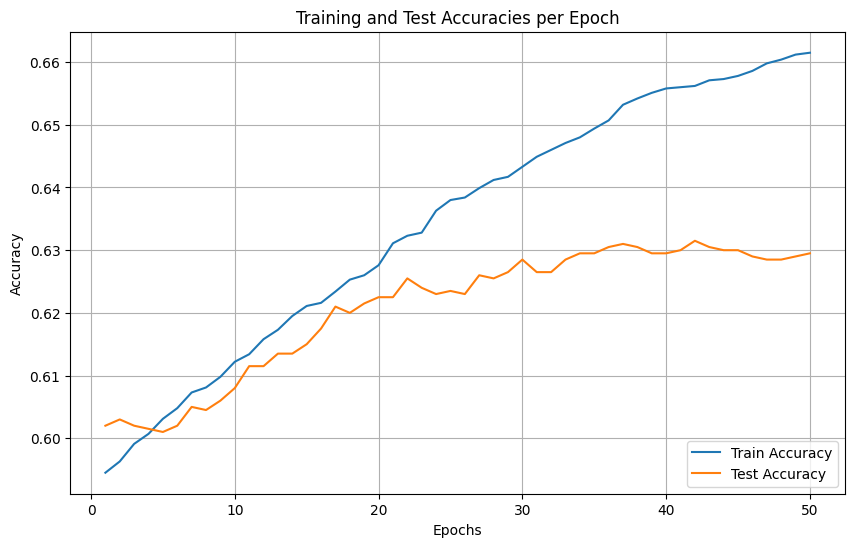

In [16]:
train_accuracies_np = cp.asnumpy(cp.array(train_accuracies))
test_accuracies_np = cp.asnumpy(cp.array(test_accuracies))

epochs = range(1, len(train_accuracies_np) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies_np, label='Train Accuracy')
plt.plot(epochs, test_accuracies_np, label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

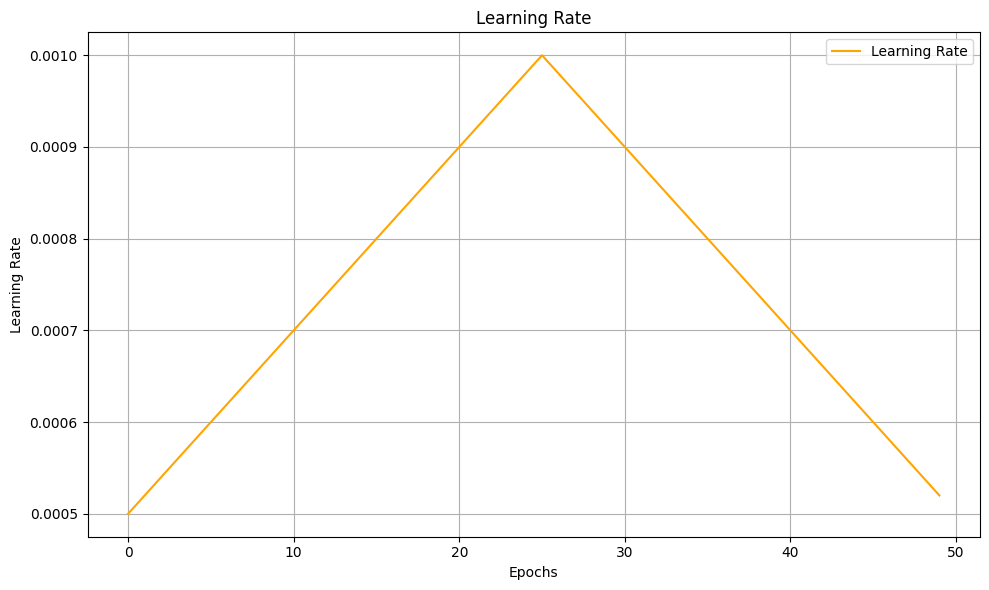

In [17]:

plt.figure(figsize=(10, 6))
plt.plot(lr_history, label='Learning Rate', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


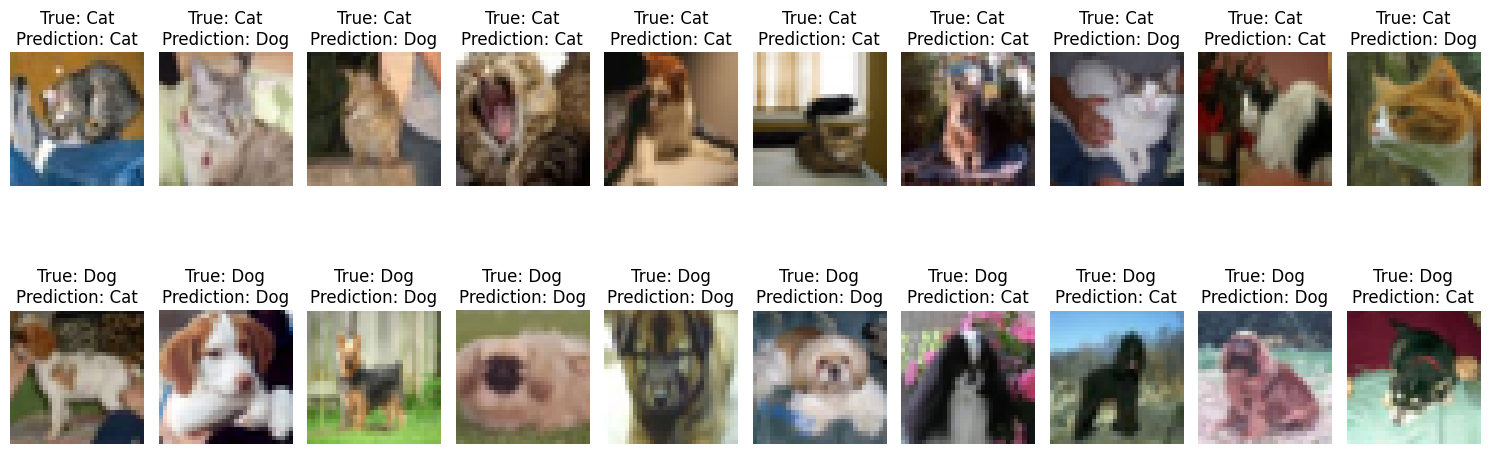

In [ ]:
cat_indices = np.where(y_test_cpu == -1)[0]  
dog_indices = np.where(y_test_cpu == 1)[0]   

# Select the first 10 cats and 10 dogs
cat_indices = cat_indices[:10]
dog_indices = dog_indices[:10]

# Combine and ensure consistent order (cats followed by dogs)
selected_indices = np.concatenate([cat_indices, dog_indices])

# Get the images, true labels, and predicted labels
sample_images = x_test[selected_indices]
sample_true_labels = y_test_cpu[selected_indices]
sample_pred_labels = y_pred_test_cpu[selected_indices]

# Map labels back to class names
label_map_inv = {1: 'Dog', -1: 'Cat'}
true_label_names = [label_map_inv[label] for label in sample_true_labels]
pred_label_names = [label_map_inv[label] for label in sample_pred_labels]

# Reverse scaling to get original pixel values
sample_images_np = sample_images.get()  # Convert CuPy to NumPy
sample_images_original = scaler.inverse_transform(sample_images_np)

# Plot the images
plt.figure(figsize=(15, 6))
for idx in range(len(selected_indices)):
    plt.subplot(2, len(selected_indices) // 2, idx + 1)
    image = sample_images_original[idx].reshape(32, 32, 3)
    image = np.clip(image, 0, 255).astype('uint8')
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True: {true_label_names[idx]}\nPrediction: {pred_label_names[idx]}")
plt.tight_layout()
plt.show()
